In [13]:
# CartPole Env
import gym
import matplotlib as plt

class CartPoleEnv:
    def __init__(self):
        self.fps = 30
        self.env = gym.make('CartPole-v0')  # environment interface to game
        self.env.seed(42)
        self.env.reset()
        self.is_show = False
        self.current_sate = []
        self.is_done = False

    def render(self):
        self.env.render()
        
    def reset(self, is_show = False):
        state = self.env.reset()
        state = state.tolist()
        self.current_sate = state
        self.is_done = False
        self.is_show = is_show
        if self.is_show:
            self.env.render()

        return state
    
    def act(self, action):
        if self.is_show:
            self.env.render()
        # return observation, reward, done, info
        state, reward, is_done, info = self.env.step(self.get_action_set()[action])
        state = state.tolist()
        self.current_sate = state
        self.is_done = is_done
        return state, reward, is_done, info

    def get_num_actions(self):
        return 2

    def get_action_set(self):
        return [0, 1]

    def get_screen_rgb(self):
        pass

    def get_screen_gray(self):
        pass

    def get_num_state_features(self):
        return 4

    def get_state(self):
        return self.current_sate

    def is_over(self):
        return self.is_done


In [14]:
# !pip install pygame
# !git clone https://github.com/ntasfi/PyGame-Learning-Environment.git
# !pip install -e ./PyGame-Learning-Environment

In [15]:
from ple.games.flappybird import FlappyBird as flappyBird
from ple import PLE

class FlappyBirdEnv:
    def __init__(self):
        self.fps = 30
        self.game = flappyBird()
        self.env = PLE(self.game, fps=self.fps, display_screen=False)  # environment interface to game
        self.env.reset_game()

    def reset(self, is_show = False):
        self.env = PLE(self.game, fps=self.fps, display_screen=is_show)  # environment interface to game
        self.env.reset_game()
        state = self.get_state()

        return state
    
    def act(self, action):
        # return state_prime, reward, done, info
        reward = self.env.act(self.env.getActionSet()[action])
        
        # Survive reward +1
#         reward += 1
        
        # Get closer to the middle of top and bottom pipe and get more reward
#         state = self.game.getGameState()
        
#         next_dis_to_mid = abs((state['next_pipe_top_y'] + state['next_pipe_bottom_y']) / 2 - state['player_y'])
#         print('State')
#         print(state)
#         print('Mid')
#         print((state['next_pipe_top_y'] + state['next_pipe_bottom_y']) / 2)
#         print('next_dis_to_mid')
#         print(abs((state['next_pipe_top_y'] + state['next_pipe_bottom_y']) / 2 - state['player_y']))
#         next_next_dis_to_mid = abs((state['next_next_pipe_top_y'] + state['next_next_pipe_bottom_y']) / 2 - state['player_y'])
#         dis_reward_coef = 0.01
        
#         reward += dis_reward_coef * ((-next_dis_to_mid) + 0.5 * (-next_next_dis_to_mid))
        
        state_prime = self.get_state()
        is_done = self.is_over()
        info = ""
        return state_prime, reward, is_done, info

    def get_num_actions(self):
        return len(self.env.getActionSet())

    def get_action_set(self):
        return self.env.getActionSet()

    def get_screen_rgb(self):
        return self.env.getScreenRGB()

    def get_screen_gray(self):
        return self.env.getScreenGrayscale()

    def get_num_state_features(self):
        return len(self.game.getGameState())

    def get_state(self):
        # dict
        #     * player y position.
        #     * players velocity.
        #     * next pipe distance to player
        #     * next pipe top y position
        #     * next pipe bottom y position
        #     * next next pipe distance to player
        #     * next next pipe top y position
        #     * next next pipe bottom y position

        # state = {
        #     "player_y": self.player.pos_y,
        #     "player_vel": self.player.vel,
            
        #     "next_pipe_dist_to_player": next_pipe.x - self.player.pos_x,
        #     "next_pipe_top_y": next_pipe.gap_start,
        #     "next_pipe_bottom_y": next_pipe.gap_start+self.pipe_gap, 
            
        #     "next_next_pipe_dist_to_player": next_next_pipe.x - self.player.pos_x,
        #     "next_next_pipe_top_y": next_next_pipe.gap_start,
        #     "next_next_pipe_bottom_y": next_next_pipe.gap_start+self.pipe_gap 
        # }
        state = self.game.getGameState()
        state['next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_next_pipe_bottom_y'] -= state['player_y']
        return list(state.values())

    def is_over(self):
        return self.env.game_over()


In [16]:
import numpy as np

class EpsilonGreedy:
    def __init__(self, epsilon, num_action, min_epsilon = 0.01, decay = 0.99):
        self.epsilon = epsilon
        self.num_action = num_action
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.action_time = 0

    def select_action(self):
        self.action_time += 1
        if np.random.rand() < self.epsilon:
            self.update_epsilon()
            return np.random.choice(self.num_action)
        else: 
            self.update_epsilon()
            return -1
    
    def update_epsilon(self):
        self.epsilon = max(self.min_epsilon, min(0.5, 0.99**(self.action_time / 30)))
    
    def shutdown_explore(self):
        self.epsilon = 0

In [17]:
import tensorflow as tf
import numpy as np

class Agent:
    def __init__(self, state_size, num_action, reward_discount, learning_rate, exploration_strategy):
        self.state_size = state_size
        self.num_action = num_action
        self.reward_discount = reward_discount
        self.exploration_strategy = exploration_strategy
        self.eps = 0
        self.data_type = tf.float32
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        self.avg_loss = tf.keras.metrics.Mean(name = 'loss')
        self.model = self.build_model('model')
        self.is_shutdown_explore = False

        # For A2C loss function coefficients
        self.coef_entropy = 1.5
        self.coef_value = 1

    def build_model(self, name):
        # # Shared layers
        # nn_input = tf.keras.Input(shape = self.state_size, dtype = self.data_type)
        # x = tf.keras.layers.Dense(units = 64)(nn_input)
        # x = tf.keras.layers.ReLU()(x)
        # x = tf.keras.layers.Dense(units = 128)(x)
        # common = tf.keras.layers.ReLU()(x)

        # # Actor Model
        # actor_layer = tf.keras.layers.Dense(units = 64)(common)
        # actor_layer = tf.keras.layers.ReLU()(actor_layer)
        # actor_layer = tf.keras.layers.Dense(units = self.num_action)(actor_layer)
        # actor_nn_output = tf.keras.activations.softmax(actor_layer)

        # # Critic Model
        # critic_layer = tf.keras.layers.Dense(units = 64)(common)
        # critic_layer = tf.keras.layers.ReLU()(critic_layer)
        # critic_nn_output = tf.keras.layers.Dense(units = 1)(critic_layer)

        # # Combine into a model
        # model = tf.keras.Model(name = name, inputs = nn_input, outputs = [actor_nn_output, critic_nn_output])

        inputs = tf.keras.layers.Input(shape=self.state_size)
        x = tf.keras.layers.Dense(128, activation="relu")(inputs)
        common = tf.keras.layers.Dense(128, activation="relu")(x)
        action = tf.keras.layers.Dense(self.num_action, activation="softmax")(common)
        critic = tf.keras.layers.Dense(1)(common)

        model = tf.keras.Model(name = name, inputs=inputs, outputs=[action, critic])

        return model

    def predict(self, state):
        return self.model(tf.convert_to_tensor(state, self.data_type))

    def loss(self, action_probs, critic_values, rewards):
        # Calculate accumulated reward Q(s, a) with discount
        np_rewards = np.array(rewards)
        num_reward = np_rewards.shape[0]
        discounts = np.logspace(0, num_reward, base = self.reward_discount, num = num_reward)
        
        q_values = np.zeros(num_reward)
        for i in range(num_reward):
            q_values[i] = np.sum(np.multiply(np_rewards[i:], discounts[:num_reward - i]))
        q_values = (q_values - np.mean(q_values)) / (np.std(q_values) + 1e-9)

        # Calculate the Actor Loss and Advantage A(s, a) = Q_value(s, a) - value(s)
        action_log_prbs = tf.math.log(action_probs)
        advs = q_values - critic_values
        actor_loss = -action_log_prbs * advs
        
        # Calculate the critic loss 
        huber = tf.keras.losses.Huber()
        critic_loss = huber(tf.convert_to_tensor(critic_values, dtype = self.data_type), tf.convert_to_tensor(q_values, dtype = self.data_type))

        # Calculate the cross entropy of action distribution
        entropy = tf.reduce_sum(action_probs * action_log_prbs * -1)
        
        # Compute loss as formular: loss = Sum of a trajectory(-log(Pr(s, a| Theta)) * Advantage + coefficient of value * Value - coefficient of entropy * cross entropy of action distribution)
        # Advantage: A(s, a) = Q_value(s, a) - value(s)
        # The modification refer to the implement of Baseline A2C from OpenAI
        # Update model with a trajectory Every time.
        return tf.reduce_sum(actor_loss + self.coef_value * critic_loss - self.coef_entropy * entropy)

    def get_metrics_loss(self):
        return self.avg_loss.result()
    
    def reset_metrics_loss(self):
        self.avg_loss.reset_states()

    def select_action(self, state):
        # Predict the probability of each action(Stochastic Policy)
        act_dist, value = self.predict([state])
        act_dist = tf.squeeze(act_dist)
        value = tf.squeeze(value)
        # Assume using Epsilon Greedy Strategy
        action = self.exploration_strategy.select_action()
        
        # If the index of action (return value) is -1, choose the action with highest probability that model predict
#         if action == -1 or self.shutdown_explore == True:
#             # Pick then action with HIGHTEST probability
#             act_idx = tf.argmax(act_dist, axis = 0).numpy()
#             return act_idx, act_dist, value
#         else:
#             # If the index of action (return value) is != -1, act randomly    
#             return action, act_dist, value
        return np.random.choice(self.num_action, p=np.squeeze(act_dist)), act_dist, value

    def shutdown_explore(self):
        self.is_shutdown_explore = True
        self.exploration_strategy.shutdown_explore()
    
    def update(self, loss, tape):
        gradients = tape.gradient(loss, self.model.trainable_variables)
        # gradients = [gradients if gradients is not None else tf.zeros_like(var) for var, grad in zip(self.model.trainable_variables, gradients)]
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.avg_loss.update_state(loss)

        # Update exploration rate of Epsilon Greedy Strategy
        self.exploration_strategy.update_epsilon()

        self.eps += 1

    def train_on_env(self, env, is_show = False):
        with tf.GradientTape() as tape:
            tape.watch(self.model.trainable_variables)
            episode_reward = 0
            state = env.reset(is_show)

            action_probs = []
            critic_values = []
            rewards = []

            while not env.is_over():
                # env.render()
                action, act_prob_dist, value = self.select_action(state)
                
                act_prob = act_prob_dist[action]
                state_prime, reward, is_done, info = env.act(action)
                # print(f'State: {state}, Action: {action}, Reward: {reward}, State_Prime: {state_prime}')

                state = state_prime
                episode_reward += reward

                action_probs.append(act_prob)
                critic_values.append(value)
                rewards.append(reward)

            loss = self.loss(action_probs, critic_values, rewards)
            self.update(loss, tape)
            env.reset()

            return episode_reward, loss

4 Physical GPUs, 1 Logical GPUs
Episode 1



Avgerage Accumulated Reward: -5 | Loss: 606.153076171875
Episode 51



Avgerage Accumulated Reward: -5 | Loss: 181.6160125732422
Episode 101



Avgerage Accumulated Reward: -5 | Loss: 107.29521179199219
Episode 151



Avgerage Accumulated Reward: -5 | Loss: 107.89985656738281
Episode 201



Avgerage Accumulated Reward: -5 | Loss: 65.92730712890625
Episode 251



Avgerage Accumulated Reward: -5 | Loss: 101.25994873046875
Episode 301



Avgerage Accumulated Reward: -5 | Loss: 78.04361724853516
Episode 351



Avgerage Accumulated Reward: -5 | Loss: 35.115116119384766
Episode 401



Avgerage Accumulated Reward: -5 | Loss: 11.860280990600586
Episode 451



Avgerage Accumulated Reward: -5 | Loss: 15.07702922821045
Episode 501



Avgerage Accumulated Reward: -5 | Loss: 18.051151275634766
Episode 551



Avgerage Accumulated Reward: -5 | Loss: 19.11495590209961
Episode 601



Avgerage Accumulated Reward: -5 | Loss: 11.879219055175781
Episode 651



Avgerage Accumulated Reward: -5 | Loss: 10.918200492858887
Episode 701



Avgerage Accumulated Reward: -5 | Loss: 21.998483657836914
Episode 751



Avgerage Accumulated Reward: -5 | Loss: 8.269617080688477
Episode 801



Avgerage Accumulated Reward: -5 | Loss: 9.423725128173828
Episode 851



Avgerage Accumulated Reward: -5 | Loss: 0.712795615196228
Episode 901



Avgerage Accumulated Reward: -5 | Loss: 2.2054975032806396
Episode 951



Avgerage Accumulated Reward: -5 | Loss: 6.531569957733154
Episode 1001



Avgerage Accumulated Reward: -5 | Loss: 2.1192097663879395
Episode 1051



Avgerage Accumulated Reward: -5 | Loss: 0.4479793310165405
Episode 1101



Avgerage Accumulated Reward: -5 | Loss: 0.2126186490058899
Episode 1151



Avgerage Accumulated Reward: -5 | Loss: 0.6485067009925842
Episode 1201



Avgerage Accumulated Reward: -5 | Loss: 9.785855293273926
Episode 1251



Avgerage Accumulated Reward: -5 | Loss: 1.7006545066833496
Episode 1301



Avgerage Accumulated Reward: -5 | Loss: 20.06502342224121
Episode 1351



Avgerage Accumulated Reward: -5 | Loss: 28.832714080810547
Episode 1401



Avgerage Accumulated Reward: -5 | Loss: 8.553360939025879
Episode 1451



Avgerage Accumulated Reward: -5 | Loss: 1.3821781873703003
Episode 1501



Avgerage Accumulated Reward: -5 | Loss: 0.5872985124588013
Episode 1551



Avgerage Accumulated Reward: -5 | Loss: 0.2626471221446991
Episode 1601



Avgerage Accumulated Reward: -5 | Loss: 0.1644030064344406
Episode 1651



Avgerage Accumulated Reward: -5 | Loss: 0.11518894135951996
Episode 1701



Avgerage Accumulated Reward: -5 | Loss: 0.1608159989118576
Episode 1751



Avgerage Accumulated Reward: -5 | Loss: 0.13810411095619202
Episode 1801



Avgerage Accumulated Reward: -5 | Loss: 0.08389919996261597
Episode 1851



Avgerage Accumulated Reward: -5 | Loss: 0.09337905049324036
Episode 1901



Avgerage Accumulated Reward: -5 | Loss: 0.07179220020771027
Episode 1951



Avgerage Accumulated Reward: -5 | Loss: 0.06311289221048355
Episode 2001



Avgerage Accumulated Reward: -5 | Loss: 0.09350056946277618
Episode 2051



Avgerage Accumulated Reward: -5 | Loss: 0.09413115680217743
Episode 2101



Avgerage Accumulated Reward: -5 | Loss: 0.06171359866857529
Episode 2151



Avgerage Accumulated Reward: -5 | Loss: 0.07340562343597412
Episode 2201



Avgerage Accumulated Reward: -5 | Loss: 0.07862420380115509
Episode 2251



Avgerage Accumulated Reward: -5 | Loss: 0.059931498020887375
Episode 2301



Avgerage Accumulated Reward: -5 | Loss: 0.10559942573308945
Episode 2351



Avgerage Accumulated Reward: -5 | Loss: 0.14638783037662506
Episode 2401



Avgerage Accumulated Reward: -5 | Loss: 0.18928058445453644
Episode 2451



Avgerage Accumulated Reward: -5 | Loss: 0.05423232913017273
Episode 2501



Avgerage Accumulated Reward: -5 | Loss: 0.15383891761302948
Episode 2951



Avgerage Accumulated Reward: -5 | Loss: 1.0574079751968384
Episode 3001



Avgerage Accumulated Reward: -5 | Loss: 6.617269515991211
Episode 3051



Avgerage Accumulated Reward: -5 | Loss: 8.485738754272461
Episode 3101



Avgerage Accumulated Reward: -5 | Loss: 1.6134321689605713
Episode 3151



Avgerage Accumulated Reward: -5 | Loss: 1.1847244501113892
Episode 3201



Avgerage Accumulated Reward: -5 | Loss: 0.8696580529212952
Episode 3251



Avgerage Accumulated Reward: -5 | Loss: 0.23179864883422852
Episode 3301



Avgerage Accumulated Reward: -5 | Loss: 0.10214167833328247
Episode 3351



Avgerage Accumulated Reward: -5 | Loss: 0.1739106923341751
Episode 3401



Avgerage Accumulated Reward: -5 | Loss: 0.8683975338935852
Episode 3451



Avgerage Accumulated Reward: -5 | Loss: 8.216297149658203
Episode 3501



Avgerage Accumulated Reward: -5 | Loss: 4.16827917098999
Episode 3551



Avgerage Accumulated Reward: -5 | Loss: 0.46401143074035645
Episode 3601



Avgerage Accumulated Reward: -5 | Loss: 0.22071188688278198
Episode 3651



Avgerage Accumulated Reward: -5 | Loss: 0.15563195943832397
Episode 3701



Avgerage Accumulated Reward: -5 | Loss: 0.09788233786821365
Episode 3751



Avgerage Accumulated Reward: -5 | Loss: 0.052450619637966156
Episode 3801



Avgerage Accumulated Reward: -5 | Loss: 0.045643892139196396
Episode 3851



Avgerage Accumulated Reward: -5 | Loss: 0.04928258806467056
Episode 3901



Avgerage Accumulated Reward: -5 | Loss: 0.06071878597140312
Episode 3951



Avgerage Accumulated Reward: -5 | Loss: 0.04309516027569771
Episode 4001



Avgerage Accumulated Reward: -5 | Loss: 0.05446299538016319
Episode 4051



Avgerage Accumulated Reward: -5 | Loss: 0.056219786405563354
Episode 4101



Avgerage Accumulated Reward: -5 | Loss: 0.03474864736199379
Episode 4151



Avgerage Accumulated Reward: -5 | Loss: 0.06807587295770645
Episode 4201



Avgerage Accumulated Reward: -5 | Loss: 0.07688756287097931
Episode 4251



Avgerage Accumulated Reward: -5 | Loss: 0.03437935933470726
Episode 4301



Avgerage Accumulated Reward: -5 | Loss: 0.03952638804912567
Episode 4351



Avgerage Accumulated Reward: -5 | Loss: 0.0195245873183012
Episode 4401



Avgerage Accumulated Reward: -5 | Loss: 0.02204897254705429
Episode 4451



Avgerage Accumulated Reward: -5 | Loss: 0.03981387987732887
Episode 4501



Avgerage Accumulated Reward: -5 | Loss: 0.06209429353475571
Episode 4551



Avgerage Accumulated Reward: -5 | Loss: 0.023848164826631546
Episode 4601



Avgerage Accumulated Reward: -5 | Loss: 0.06941287964582443
Episode 4651



Avgerage Accumulated Reward: -5 | Loss: 0.07592926919460297
Episode 4701



Avgerage Accumulated Reward: -5 | Loss: 0.03730307146906853
Episode 4751



Avgerage Accumulated Reward: -5 | Loss: 0.22763867676258087
Episode 4801



Avgerage Accumulated Reward: -5 | Loss: 0.20312456786632538
Episode 4851



Avgerage Accumulated Reward: -5 | Loss: 0.08190905302762985
Episode 4901



Avgerage Accumulated Reward: -5 | Loss: 0.2203885018825531
Episode 4951



Avgerage Accumulated Reward: -5 | Loss: 0.05900636315345764
Episode 5001



Avgerage Accumulated Reward: -5 | Loss: 0.057474490255117416
Episode 5051



Avgerage Accumulated Reward: -5 | Loss: 0.07227997481822968
Episode 5101



Avgerage Accumulated Reward: -5 | Loss: 0.13686417043209076
Episode 5151



Avgerage Accumulated Reward: -5 | Loss: 0.43970221281051636
Episode 5201



Avgerage Accumulated Reward: -5 | Loss: 0.08396455645561218
Episode 5251



Avgerage Accumulated Reward: -5 | Loss: 0.33229705691337585
Episode 5301



Avgerage Accumulated Reward: -5 | Loss: 1.9118832349777222
Episode 5351



Avgerage Accumulated Reward: -5 | Loss: 16.530241012573242
Episode 5401



Avgerage Accumulated Reward: -5 | Loss: 38.5173454284668
Episode 5451



Avgerage Accumulated Reward: -5 | Loss: 5.408092021942139
Episode 5501



Avgerage Accumulated Reward: -5 | Loss: 3.231877088546753
Episode 5551



Avgerage Accumulated Reward: -5 | Loss: 0.7176723480224609
Episode 5601



Avgerage Accumulated Reward: -5 | Loss: 0.4797920286655426
Episode 5651



Avgerage Accumulated Reward: -5 | Loss: 0.317618191242218
Episode 5701



Avgerage Accumulated Reward: -5 | Loss: 0.18559645116329193
Episode 5751



Avgerage Accumulated Reward: -5 | Loss: 0.1948103904724121
Episode 5801



Avgerage Accumulated Reward: -5 | Loss: 0.1406441479921341
Episode 5851



Avgerage Accumulated Reward: -5 | Loss: 0.11763259023427963
Episode 5901



Avgerage Accumulated Reward: -5 | Loss: 0.08055204153060913
Episode 5951



Avgerage Accumulated Reward: -5 | Loss: 0.09127498418092728
Episode 6001



Avgerage Accumulated Reward: -5 | Loss: 0.08041837811470032
Episode 6051



Avgerage Accumulated Reward: -5 | Loss: 0.06440380215644836
Episode 6101



Avgerage Accumulated Reward: -5 | Loss: 0.06630419194698334
Episode 6151



Avgerage Accumulated Reward: -5 | Loss: 0.07291339337825775
Episode 6201



Avgerage Accumulated Reward: -5 | Loss: 0.044944509863853455
Episode 6251



Avgerage Accumulated Reward: -5 | Loss: 0.0827898308634758
Episode 6301



Avgerage Accumulated Reward: -5 | Loss: 0.04817274957895279
Episode 6351



Avgerage Accumulated Reward: -5 | Loss: 0.059529323130846024
Episode 6401



Avgerage Accumulated Reward: -5 | Loss: 0.03917689621448517
Episode 6451



Avgerage Accumulated Reward: -5 | Loss: 0.04022189974784851
Episode 6501



Avgerage Accumulated Reward: -5 | Loss: 0.03839374706149101
Episode 6551



Avgerage Accumulated Reward: -5 | Loss: 0.1460060030221939
Episode 6601



Avgerage Accumulated Reward: -5 | Loss: 0.15529270470142365
Episode 6651



Avgerage Accumulated Reward: -5 | Loss: 0.07421904802322388
Episode 6701



Avgerage Accumulated Reward: -5 | Loss: 0.0888684019446373
Episode 6751



Avgerage Accumulated Reward: -5 | Loss: 0.0462903268635273
Episode 6801



Avgerage Accumulated Reward: -5 | Loss: 0.0350763238966465
Episode 6851



Avgerage Accumulated Reward: -5 | Loss: 0.038037218153476715
Episode 6901



Avgerage Accumulated Reward: -5 | Loss: 0.03294362127780914
Episode 6951



Avgerage Accumulated Reward: -5 | Loss: 0.03643070161342621
Episode 7001



Avgerage Accumulated Reward: -5 | Loss: 0.022004563361406326
Episode 7051



Avgerage Accumulated Reward: -5 | Loss: 0.04911572113633156
Episode 7101



Avgerage Accumulated Reward: -5 | Loss: 0.09310241788625717
Episode 7151



Avgerage Accumulated Reward: -5 | Loss: 0.3265271782875061
Episode 7201



Avgerage Accumulated Reward: -5 | Loss: 0.6754692196846008
Episode 7251



Avgerage Accumulated Reward: -5 | Loss: 0.18070457875728607
Episode 7301



Avgerage Accumulated Reward: -5 | Loss: 0.07226115465164185
Episode 7351



Avgerage Accumulated Reward: -5 | Loss: 0.050844430923461914
Episode 7401



Avgerage Accumulated Reward: -5 | Loss: 0.03273596614599228
Episode 7451



Avgerage Accumulated Reward: -5 | Loss: 0.04481305927038193
Episode 7501



Avgerage Accumulated Reward: -5 | Loss: 0.06761790066957474
Episode 7551



Avgerage Accumulated Reward: -5 | Loss: 0.028519248589873314
Episode 7601



Avgerage Accumulated Reward: -5 | Loss: 0.027355534955859184
Episode 7651



Avgerage Accumulated Reward: -5 | Loss: 0.036859698593616486
Episode 7701



Avgerage Accumulated Reward: -5 | Loss: 0.04447706788778305
Episode 7751



Avgerage Accumulated Reward: -5 | Loss: 0.02280818484723568
Episode 7801



Avgerage Accumulated Reward: -5 | Loss: 0.03328894078731537
Episode 7851



Avgerage Accumulated Reward: -5 | Loss: 0.01954873837530613
Episode 7901



Avgerage Accumulated Reward: -5 | Loss: 0.032819412648677826
Episode 7951



Avgerage Accumulated Reward: -5 | Loss: 0.04154287278652191
Episode 8001



Avgerage Accumulated Reward: -5 | Loss: 14.134810447692871
Episode 8051



Avgerage Accumulated Reward: -5 | Loss: -979.12451171875
Episode 8101



Avgerage Accumulated Reward: -5 | Loss: -1549.45068359375
Episode 8151



Avgerage Accumulated Reward: -5 | Loss: -1519.3740234375
Episode 8201



Avgerage Accumulated Reward: -5 | Loss: -1489.0467529296875
Episode 8251



Avgerage Accumulated Reward: -5 | Loss: -1508.1556396484375
Episode 8301



Avgerage Accumulated Reward: -5 | Loss: -1535.2264404296875
Episode 8351



Avgerage Accumulated Reward: -5 | Loss: -1407.114501953125
Episode 8401



Avgerage Accumulated Reward: -5 | Loss: -1495.3935546875
Episode 8451



Avgerage Accumulated Reward: -5 | Loss: -1565.8848876953125
Episode 8501



Avgerage Accumulated Reward: -5 | Loss: -1554.888916015625
Episode 8551



Avgerage Accumulated Reward: -5 | Loss: -1560.88525390625
Episode 8601



Avgerage Accumulated Reward: -5 | Loss: -1468.397216796875
Episode 8651



Avgerage Accumulated Reward: -5 | Loss: -1455.7991943359375
Episode 8701



Avgerage Accumulated Reward: -5 | Loss: -1537.1356201171875
Episode 8751



Avgerage Accumulated Reward: -5 | Loss: -1523.826416015625
Episode 8801



Avgerage Accumulated Reward: -5 | Loss: -1368.7060546875
Episode 8851



Avgerage Accumulated Reward: -5 | Loss: -1512.499267578125
Episode 8901



Avgerage Accumulated Reward: -5 | Loss: -1488.25927734375
Episode 8951



Avgerage Accumulated Reward: -5 | Loss: -1396.2650146484375
Episode 9001



Avgerage Accumulated Reward: -5 | Loss: -1604.742919921875
Episode 9051



Avgerage Accumulated Reward: -5 | Loss: -1514.0849609375
Episode 9101



Avgerage Accumulated Reward: -5 | Loss: -1322.3399658203125
Episode 9151



Avgerage Accumulated Reward: -5 | Loss: -1602.1634521484375
Episode 9201



Avgerage Accumulated Reward: -5 | Loss: -1568.607666015625
Episode 9251



Avgerage Accumulated Reward: -5 | Loss: -1477.94482421875
Episode 9301



Avgerage Accumulated Reward: -5 | Loss: -1478.7222900390625
Episode 9351



Avgerage Accumulated Reward: -5 | Loss: -1500.5450439453125
Episode 9401



Avgerage Accumulated Reward: -5 | Loss: -1485.3612060546875
Episode 9451



Avgerage Accumulated Reward: -5 | Loss: -1499.85107421875
Episode 9501



Avgerage Accumulated Reward: -5 | Loss: -1496.4329833984375
Episode 9551



Avgerage Accumulated Reward: -5 | Loss: -1541.3677978515625
Episode 9601



Avgerage Accumulated Reward: -5 | Loss: -1486.060302734375
Episode 9651



Avgerage Accumulated Reward: -5 | Loss: -1390.3076171875
Episode 9701



Avgerage Accumulated Reward: -5 | Loss: -1511.2659912109375
Episode 9751



Avgerage Accumulated Reward: -5 | Loss: -1554.7098388671875
Episode 9801



Avgerage Accumulated Reward: -5 | Loss: -1482.56982421875
Episode 9851



Avgerage Accumulated Reward: -5 | Loss: -1531.186767578125
Episode 9901



Avgerage Accumulated Reward: -5 | Loss: -1418.2073974609375
Episode 9951



Accumulated Reward: -5 | Loss: -1550.8443603515625
Evaluate
Accumulated Reward: -5


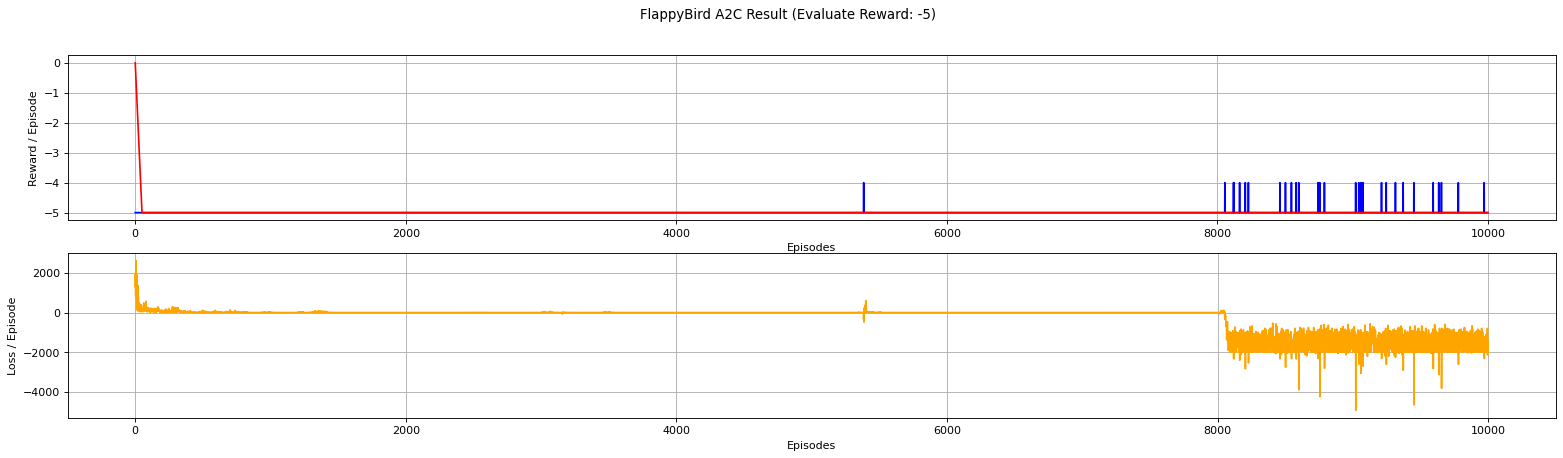

In [18]:
# CartPole-A2C Experiment
# 2020/08/11 SYC 

# import models.A2C as A2C
# import models.expStrategy.epsilonGreedy as EPSG
# import envs.cartPole as cartPole
import models.util as Util
import logging
import matplotlib.pyplot as plt
from matplotlib.pylab import figure
import os
import numpy as np
# To run tqdm on notebook, import tqdm.notebook
from tqdm.notebook import tqdm
# Run on pure python
# from tqdm import tqdm

# Config Logging format
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
# Config logging module to enable on notebook
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)

# Block any pop-up windows
os.environ['SDL_VIDEODRIVER'] = 'dummy'

# Test GPU and show the available logical & physical GPUs
Util.test_gpu()

env = FlappyBirdEnv()
NUM_STATE_FEATURES = env.get_num_state_features()
NUM_ACTIONS = env.get_num_actions()
EPISODE_NUM = 10000
PRINT_EVERY_EPISODE = 50
LEARNING_RATE = 0.003
REWARD_DISCOUNT = 0.99

exp_stg = EpsilonGreedy(0.2, NUM_ACTIONS)
agent = Agent((NUM_STATE_FEATURES, ), NUM_ACTIONS, REWARD_DISCOUNT, LEARNING_RATE, exp_stg)

state = env.reset()
accum_reward = 0

# tqdm progress bar
bar = []
# Reward & LossHistory
r_his = []
avg_r_his = [0]
loss_his = []
episode_reward = 0

print("Episode 1")
for episode in range(1, EPISODE_NUM + 1):
    if episode % PRINT_EVERY_EPISODE == 1:
        if episode > 1:
            bar.close()
            print("Avgerage Accumulated Reward: {} | Loss: {}".format(round(accum_reward / PRINT_EVERY_EPISODE), agent.get_metrics_loss()))
            print("Episode {}".format(episode))
            agent.reset_metrics_loss()
            avg_r_his.append(round(accum_reward / PRINT_EVERY_EPISODE))
            accum_reward = 0
        bar = tqdm(total = PRINT_EVERY_EPISODE)

    episode_reward, episode_loss = agent.train_on_env(env)
    accum_reward += episode_reward
    r_his.append(episode_reward)
    loss_his.append(episode_loss)
    
    episode_reward = 0

    bar.update(1)        
    env.reset()

bar.close()    
print("Accumulated Reward: {} | Loss: {}".format(round(accum_reward / PRINT_EVERY_EPISODE), agent.get_metrics_loss()))
avg_r_his.append(round(accum_reward / PRINT_EVERY_EPISODE))
agent.reset_metrics_loss()

# Evaluate the model
agent.shutdown_explore()
agent.reset_metrics_loss()
# Reset Game
env_state = env.reset()
accum_reward = 0

while not env.is_over():
    # env.render()
    action, act_log_prob, value = agent.select_action(state)
    state_prime, reward, is_done, info = env.act(action)

    state = state_prime
    accum_reward += reward

print("Evaluate")
print("Accumulated Reward: {}".format(round(accum_reward)))

# Plot Reward History
# figure(num=None, figsize=(24, 6), dpi=80)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 6), dpi=80)
fig.suptitle(f'FlappyBird A2C Result (Evaluate Reward: {round(accum_reward)})')
x_datas = range(0, len(r_his))
avg_x_datas = range(0, EPISODE_NUM + 1, PRINT_EVERY_EPISODE)

ax1.plot(x_datas, r_his, color='blue')
ax1.plot(avg_x_datas, avg_r_his, color='red')
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Reward / Episode')
ax1.grid()

ax2.plot(x_datas, loss_his, color='orange')
ax2.set_xlabel('Episodes')
ax2.set_ylabel('Loss / Episode')
ax2.grid()

plt.savefig('FlappyBird-A2C-res.svg')
plt.show()